# Import packages

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time, warnings
warnings.filterwarnings("ignore")
# from utils import A_cluster
from tqdm.auto import tqdm
from torchvision import transforms, datasets
from copy import deepcopy

# Configuration

In [4]:
class config:
    input = 700
    output = 20
    hid = 512         # number of RC Neurons
    thr = 0.5
    b_j0 = 0.01       # thr baseline
    dt = 1
    R_m = 1
    decay = 0.5
    rst = 0.05
    lens = 0.5
    gamma = 0.5       # gradient scale 
    gradient_type = 'G' # 'MG', 'slayer', 'linear' 窗型函数
    scale = 6.        # special for 'MG'
    hight = 0.15      # special for 'MG'

    N_hid = hid
    p_in = 0.2        # ratio of inhibitory neurons
    # gamma = 1.0       # shape factor of gamma distribution
    binary = True    # binary matrix of reservoir A
    net_type = 'BAC'  # type of reservoir connection topology
                      # 'ER',  # Erdos-Renyi Random Network
                      # 'ERC', # Clusters of Erdos-Renyi Networks
                      # 'BA',  # Barabasi-Albert Network
                      # 'BAC', # Clusters of Barabasi-Albert networks
                      # 'WS',  # Watts Strogatz small world networks
                      # 'WSC', # Clusters of Watts Strogatz small world networks
                      # 'RAN', # random network
                      # 'DTW', # Developmental Time Window for multi-cluster small-world network
    noise = True      # add noise in A
    noise_str = 0.05  # noise strength
    p_ER = 0.2        # connection probability when creating edges, for ER and WS graphs
    m_BA = 3          # number of edges to attach from a new node to existing nodes
    k = 5             # number of clusters in A
    R = 0.2           # distance factor when deciding connections in random network
    scale = False     # rescale matrix A with spectral radius
    
    input_learn = True # learnable input layer
    seed = 123
    trials = 5        # try on 5 different seeds
    num_minibatch = 10000
    num_per_label_minibatch = 20 # number of samples of each label in one mini-batch
    batch = 256
    epoch = 40
    lr = 0.005
    l1 = 0.0003
    l1_targ = 20000
    dropout = 0.7
    dropout_stepping = 0.01
    dropout_stop = 0.90
    weight_decay = 1e-4
    label_smoothing = False
    smoothing = 0.1
    norm = False      # add layer norm before each layer
    shortcut = False
    small_init = True
    device = torch.device('cuda')

# Load datasets

In [486]:
from torchaudio.datasets import SPEECHCOMMANDS
# SC_train = SPEECHCOMMANDS(root='./data', download=True)


In [104]:
# 脑电数据集
import scipy
def convert_dataset_wtime(mat_data):
    X = mat_data["x"]
    Y = mat_data["y"]
    t = mat_data["t"]
    Y = np.argmax(Y[:, :, :], axis=-1)
    d1,d2 =  t.shape

    # dt = np.zeros((size(t[:, 1]), size(t[1, :])))
    dt = np.zeros((d1,d2))
    for trace in range(d1):
        dt[trace, 0] = 1
        dt[trace, 1:] = t[trace, 1:] - t[trace, :-1]

    return dt, X, Y

train_mat = scipy.io.loadmat('./data/QTDB_train.mat')
test_mat = scipy.io.loadmat('./data/QTDB_test.mat')

In [8]:
train_X = np.load('data/trainX_4ms.npy')
train_y = np.load('data/trainY_4ms.npy').astype(np.float)

test_X = np.load('data/testX_4ms.npy')
test_y = np.load('data/testY_4ms.npy').astype(np.float)

print('dataset shape: ', train_X.shape)
print('dataset shape: ', test_X.shape)

tensor_trainX = torch.Tensor(train_X)  # transform to torch tensor
tensor_trainY = torch.Tensor(train_y)
train_dataset = torch.utils.data.TensorDataset(tensor_trainX, tensor_trainY)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch, shuffle=True)
tensor_testX = torch.Tensor(test_X)  # transform to torch tensor
tensor_testY = torch.Tensor(test_y)
test_dataset = torch.utils.data.TensorDataset(tensor_testX, tensor_testY)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch, shuffle=False)
plt.imshow(tensor_trainX[0].data.numpy())

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10708\4227323892.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_y = np.load('data/trainY_4ms.npy').astype(np.float)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_10708\4227323892.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_y = np.load('data/testY_4ms.npy').a

dataset shape:  (8156, 250, 700)
dataset shape:  (2264, 250, 700)


In [28]:
from spikingjelly.datasets.shd import SpikingHeidelbergDigits
SHD_train = SpikingHeidelbergDigits('D:\Ph.D\Research\SNN-SRT数据\SHD', train=True, data_type='frame', frames_number=80, split_by='number')

The directory [D:\Ph.D\Research\SNN-SRT数据\SHD\extract] for saving extracted files already exists.
SpikingJelly will not check the data integrity of extracted files.
If extracted files are not integrated, please delete [D:\Ph.D\Research\SNN-SRT数据\SHD\extract] manually, then SpikingJelly will re-extract files from [D:\Ph.D\Research\SNN-SRT数据\SHD\download].
The directory [D:\Ph.D\Research\SNN-SRT数据\SHD\frames_number_80_split_by_number] already exists.


In [60]:
index = SHD_train[10][0]>0
a = SHD_train[10][0]
a[index] = 1
(a==1).sum() + (a==0).sum() 

56000

In [63]:
from spikingjelly.datasets.shd import SpikingHeidelbergDigits
SHD_train = SpikingHeidelbergDigits('D:\Ph.D\Research\SNN-SRT数据\SHD', train=True, data_type='frame', frames_number=80, split_by='number')
SHD_test = SpikingHeidelbergDigits('D:\Ph.D\Research\SNN-SRT数据\SHD', train=False, data_type='frame', frames_number=80, split_by='number')

# 原数据集不是二值数据，需要把非零值全部置为1
SHD_train_aug = []
for x, y in SHD_train:
    x[x>0] = 1.
    SHD_train_aug.append([x, y])
    for _ in range(2):
        noise = np.array(np.random.random(x.shape)>0.95, dtype=np.float)
        x_tmp = x + noise
        x_tmp[x_tmp > 0] = 1.
        SHD_train_aug.append([x_tmp, y])

SHD_test_aug = []
for x, y in SHD_test:
    x[x>0] = 1.
    SHD_test_aug.append([x, y])

train_loader = torch.utils.data.DataLoader(dataset=SHD_train_aug, batch_size=config.batch, shuffle=True, drop_last=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset=SHD_test_aug, batch_size=config.batch, shuffle=False, drop_last=False, num_workers=0)

The directory [D:\Ph.D\Research\SNN-SRT数据\SHD\extract] for saving extracted files already exists.
SpikingJelly will not check the data integrity of extracted files.
If extracted files are not integrated, please delete [D:\Ph.D\Research\SNN-SRT数据\SHD\extract] manually, then SpikingJelly will re-extract files from [D:\Ph.D\Research\SNN-SRT数据\SHD\download].
The directory [D:\Ph.D\Research\SNN-SRT数据\SHD\frames_number_80_split_by_number] already exists.
The directory [D:\Ph.D\Research\SNN-SRT数据\SHD\extract] for saving extracted files already exists.
SpikingJelly will not check the data integrity of extracted files.
If extracted files are not integrated, please delete [D:\Ph.D\Research\SNN-SRT数据\SHD\extract] manually, then SpikingJelly will re-extract files from [D:\Ph.D\Research\SNN-SRT数据\SHD\download].
The directory [D:\Ph.D\Research\SNN-SRT数据\SHD\frames_number_80_split_by_number] already exists.


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10708\2655462638.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  noise = np.array(np.random.random(x.shape)>0.95, dtype=np.float)


In [152]:
from spikingjelly.datasets.n_mnist import NMNIST

nmnist_train = NMNIST('D:\Ph.D\Research\SNN-SRT数据/N-MNIST', train=True, data_type='frame', frames_number=20, split_by='number')
nmnist_test = NMNIST('D:\Ph.D\Research\SNN-SRT数据/N-MNIST', train=False, data_type='frame', frames_number=20, split_by='number')
train_loader = torch.utils.data.DataLoader(dataset=nmnist_train, batch_size=config.batch, shuffle=True, drop_last=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset=nmnist_test, batch_size=config.batch, shuffle=False, drop_last=False, num_workers=0)


The directory [D:\Ph.D\Research\SNN-SRT数据/N-MNIST\frames_number_20_split_by_number] already exists.
The directory [D:\Ph.D\Research\SNN-SRT数据/N-MNIST\frames_number_20_split_by_number] already exists.


In [183]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     # transforms.Normalize((0.1307,), (0.3081,))
# ])

# train_dataset = datasets.MNIST(root='./data/', train=True, transform=transform, download=True)
# test_dataset = datasets.MNIST(root='./data/', train=False, transform=transform, download=True)
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True)
# train_dataset = datasets.CIFAR100(root='./data', train=True, download=True)
# test_dataset = datasets.CIFAR100(root='./data', train=False, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=config.batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=config.batch, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


# RC Model

In [232]:
def gaussian(x, mu=0., sigma=.5):
    return torch.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) / torch.sqrt(2 * torch.tensor(torch.pi)) / sigma

class ActFun(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input.gt(0).float()

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        temp = abs(input - 0) < config.lens 
        return grad_input * temp.float()

class ActFun_adp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):  # input = membrane potential- threshold
        ctx.save_for_backward(input)
        return input.gt(0).float()  # is firing ???

    @staticmethod
    def backward(ctx, grad_output):  # approximate the gradients
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        # temp = abs(input) < lens
        if config.gradient_type == 'G':
            temp = torch.exp(-(input**2)/(2*config.lens**2))/torch.sqrt(2*torch.tensor(torch.pi))/config.lens
        elif config.gradient_type == 'MG':
            temp = gaussian(input, mu=0., sigma=config.lens) * (1. + config.hight) \
                - gaussian(input, mu=config.lens, sigma=config.scale * config.lens) * config.hight \
                - gaussian(input, mu=-config.lens, sigma=config.scale * config.lens) * config.hight
        elif config.gradient_type =='linear':
            temp = F.relu(1-input.abs())
        elif config.gradient_type == 'slayer':
            temp = torch.exp(-5*input.abs())
        return grad_input * temp.float() * config.gamma

act_fun = ActFun.apply
act_fun_adp = ActFun_adp.apply

def mem_update(op1, op2, input, mem, spk, thr, decay, rst):
    mem = rst * spk + mem * decay * (1-spk) + F.sigmoid(op2(input + op1(spk)))
    spike = act_fun(mem - thr)
    return mem, spike

def RadLIF_update(input, mem, spk, thr, alpha, beta, a, b, W):
    mem_ = alpha * mem + (1-alpha) * (input-W) - thr * spk
    W_ = beta * W + (1-beta) * a * mem + b * spk
    spike = act_fun(mem_ - thr)
    return mem_, spike, W_

def mem_update_adp(inputs, mem, spike, tau_adp, b, tau_m, dt=1, isAdapt=1):
    alpha = torch.exp(-1. * dt / tau_m).cuda()
    ro = torch.exp(-1. * dt / tau_adp).cuda()
    if isAdapt:
        beta = 1.8
    else:
        beta = 0.

    b = ro * b + (1 - ro) * spike
    B = config.b_j0 + beta * b

    mem = mem * alpha + (1 - alpha) * config.R_m * inputs - B * spike * dt
    inputs_ = mem - B
    spike = act_fun_adp(inputs_)  # act_fun : approximation firing function
    return mem, spike, B, b

# RC model design

In [218]:
def output_Neuron(inputs, mem, tau_m, dt=1):
    """
    The read out neuron is leaky integrator without spike
    """
    # alpha = torch.exp(-1. * dt / torch.FloatTensor([30.])).cuda()
    alpha = torch.exp(-1. * dt / tau_m).cuda()
    mem = mem * alpha + (1. - alpha) * config.R_m * inputs
    return mem

In [77]:
class RC_RadLIF(nn.Module):
    def __init__(self) -> None:
        super(RC_RadLIF, self).__init__()
        input = config.input
        hid = config.hid
        out = config.output
        self.fc_in = nn.Linear(input, hid)
        # self.fc_a = nn.Linear(input, hid)
        # self.fc_b = nn.Linear(input, hid)
        # self.fc_alpha = nn.Linear(input, hid)
        # self.fc_beta = nn.Linear(input, hid)
        self.A1 = nn.Linear(hid, hid, bias=True) # random initialized adjacency matrix
        
        # 用于保证input强度大于lateral connection的强度，不然没法学到东西
        # 因此邻接矩阵的权重尽可能小
        # 0初始化也行
        if config.small_init:
            self.A1.weight.data = 0.9 * self.A1.weight.data
        self.fc_out = nn.Linear(hid, out)
        
        self.thr = nn.Parameter(torch.rand(config.hid).uniform_(0.9, 1.1), requires_grad=False)
        self.a = nn.Parameter(torch.rand(config.hid).uniform_(-1, 1), requires_grad=False)
        self.b = nn.Parameter(torch.rand(config.hid).uniform_(0, 2), requires_grad=False)
        self.alpha = nn.Parameter(torch.rand(config.hid).uniform_(0.6, 0.96), requires_grad=False)
        self.beta = nn.Parameter(torch.rand(config.hid).uniform_(0.96, 0.99), requires_grad=False)
        self.fc_alpha = nn.Linear(input, hid)
        
        self.ln1 = nn.LayerNorm(hid)
        
        if not config.input_learn:
            for name, p in self.named_parameters():
                if 'conv' in name or 'fc_in' in name:
                    p.requires_grad = False
        
    def forward(self, input, mask, device='cuda', mode='serial'):
        A1_mask, A2_mask, A3_mask, A4_mask = mask
        batch = input.shape[0]
        time_step = input.shape[1]
        # input = input.view(batch, config.input)
        # if len(input.shape)>2:
        #     batch, time_step = input.shape[0:2]
        
        hid1_mem = torch.zeros(batch, time_step+1, config.hid).uniform_(0, 0.1).to(device)
        hid1_spk = torch.zeros(batch, time_step+1, config.hid).to(device)
        hid1_W = torch.zeros(batch, time_step+1, config.hid).to(device)
        sum1_spk = torch.zeros(batch, config.hid).to(device)
        sum1_mem = torch.zeros(batch, config.hid).to(device)
        hmem1 = torch.zeros(batch, config.hid).to(device)
        hspk1 = torch.zeros(batch, config.hid).to(device)
        hW1 = torch.zeros(batch, config.hid).to(device)
        self.A1.weight.data = self.A1.weight.data * A1_mask.T.to(device)
        
        for t in range(time_step):
            input_t = F.relu(self.fc_in(input[:,t,:].float()))
            # a = F.tanh(self.fc_a(input[:,t,:].float()))
            # b = 2*F.sigmoid(self.fc_b(input[:,t,:].float()))
            # alpha = F.sigmoid(self.fc_alpha(input[:,t,:].float()))
            # beta = F.sigmoid(self.fc_beta(input[:,t,:].float()))
            ########## Layer 1 ##########
            #############################
            if config.norm:
                input_t = self.ln1(input_t)
            x = self.A1(input_t)
            
            # hid1_mem_tmp, hid1_spk_tmp, hid1_W_tmp = RadLIF_update(x, hid1_mem[:,t,:], hid1_spk[:,t,:], self.thr, self.alpha, self.beta, self.a, self.b, hid1_W[:,t,:])
            hmem1, hspk1, hW1 = RadLIF_update(x, hmem1, hspk1, self.thr, self.alpha, self.beta, self.a, self.b, hW1)
            
            # hid1_mem[:,t+1,:] = hid1_mem_tmp
            # hid1_spk[:,t+1,:] = hid1_spk_tmp
            # hid1_W[:,t+1,:] = hid1_W_tmp
            # sum1_spk += hid1_spk_tmp
            # sum1_mem += F.softmax(hid1_mem_tmp)
            sum1_mem += F.softmax(hmem1)
            
        # sum1_spk /= time_step
        out = self.fc_out(sum1_mem)
        A_norm = torch.norm(self.A1.weight, p=1)
        return out, hid1_mem, hid1_spk, A_norm

In [99]:
class RC_parallel(nn.Module):
    def __init__(self) -> None:
        super(RC_parallel, self).__init__()
        input = config.input
        hid = config.hid
        out = config.output
        self.fc1 = nn.Linear(input, hid)
        self.fc2 = nn.Linear(input, hid)
        self.fc3 = nn.Linear(input, hid)
        self.fc4 = nn.Linear(input, hid)
        
        self.A1 = nn.Linear(hid, hid, bias=True) # random initialized adjacency matrix
        self.A2 = nn.Linear(hid, hid, bias=True)
        self.A3 = nn.Linear(hid, hid, bias=True)
        self.A4 = nn.Linear(hid, hid, bias=True)
        self.A1.weight.data = 0.2 * self.A1.weight.data
        self.A2.weight.data = 0.2 * self.A2.weight.data
        self.A3.weight.data = 0.2 * self.A3.weight.data
        self.A4.weight.data = 0.2 * self.A4.weight.data
        
        self.fc_out = nn.Linear(hid*4, out)
        
        self.thr = nn.Parameter(torch.rand(config.hid)*config.thr, requires_grad=True)
        self.decay = nn.Parameter(torch.rand(config.hid)*config.decay, requires_grad=True)
        self.rst = nn.Parameter(torch.rand(config.hid)*config.rst, requires_grad=True)
        
        self.ln1 = nn.LayerNorm(hid)
        self.ln2 = nn.LayerNorm(hid)
        self.ln3 = nn.LayerNorm(hid)
        self.ln4 = nn.LayerNorm(hid)
        
        if not config.input_learn:
            for name, p in self.named_parameters():
                if 'fc1' in name or 'fc2' in name or 'fc3' in name or 'fc4' in name:
                    p.requires_grad = False
    
    def mem_update(self, op1, input, mem, spk, thr, decay, rst):
        mem = rst * spk + mem * decay * (1-spk) + input + op1(spk)
        spike = act_fun(mem - thr)
        return mem, spike
    
    def forward(self, input, mask, device='cuda'):
        A1_mask, A2_mask, A3_mask, A4_mask = mask
        batch = input.shape[0]
        time_step = input.shape[1]
        # input = input.view(batch, config.input)
        # if len(input.shape)>2:
        #     batch, time_step = input.shape[0:2]
        
        hid1_mem = torch.zeros(batch, config.hid).uniform_(0, 0.1).to(device)
        hid1_spk = torch.zeros(batch, config.hid).to(device)
        
        hid2_mem = torch.zeros(batch, config.hid).uniform_(0, 0.1).to(device)
        hid2_spk = torch.zeros(batch, config.hid).to(device)
        
        hid3_mem = torch.zeros(batch, config.hid).uniform_(0, 0.1).to(device)
        hid3_spk = torch.zeros(batch, config.hid).to(device)
        
        hid4_mem = torch.zeros(batch, config.hid).uniform_(0, 0.1).to(device)
        hid4_spk = torch.zeros(batch, config.hid).to(device)
        
        sum1_spk = torch.zeros(batch, config.hid).to(device)
        sum2_spk = torch.zeros(batch, config.hid).to(device)
        sum3_spk = torch.zeros(batch, config.hid).to(device)
        sum4_spk = torch.zeros(batch, config.hid).to(device)
        
        self.A1.weight.data = self.A1.weight.data * A1_mask.T.to(device)
        self.A2.weight.data = self.A2.weight.data * A2_mask.T.to(device)
        self.A3.weight.data = self.A3.weight.data * A3_mask.T.to(device)
        self.A4.weight.data = self.A4.weight.data * A4_mask.T.to(device)
        for t in range(time_step):
            ########## Layer 1 ##########
            #############################
            x1 = F.relu(self.fc1(input[:,t,:].float()))
            if config.norm:
                x1 = self.ln1(x1)
            # x = self.A1(input_t)
            # x = x @ self.A
            # x = F.sigmoid(self.A1(x))
            # x = F.tanh(self.A1(self.ln1(input_t)))
            hid1_mem, hid1_spk = self.mem_update(self.A1, x1, hid1_mem, hid1_spk, self.thr, self.decay, self.rst)
            sum1_spk += hid1_spk
            
            ########## Layer 2 ##########
            #############################
            x2 = F.relu(self.fc2(input[:,t,:].float()))
            if config.norm:
                x2 = self.ln2(x2)
            # x = self.fc2(input_l2)
            # x = F.sigmoid(self.A2(hid1_spk_tmp))
            # x = F.tanh(self.A2(self.ln2(hid1_spk_tmp)+x))
            
            hid2_mem, hid2_spk = self.mem_update(self.A2, x2, hid2_mem, hid2_spk, self.thr, self.decay, self.rst)
            sum2_spk += hid2_spk
            
            ########## Layer 3 ##########
            #############################
            x3 = F.relu(self.fc3(input[:,t,:].float()))
            if config.norm:
                x3 = self.ln3(x3)
            # x = self.fc3(input_l3)
            # x = F.tanh(self.A3(self.ln3(hid2_spk_tmp)+x))
            # x = F.sigmoid(self.A3(hid2_spk_tmp))
            hid3_mem, hid3_spk = self.mem_update(self.A3, x3, hid3_mem, hid3_spk, self.thr, self.decay, self.rst)
            sum3_spk += hid3_spk
            
            ########## Layer 4 ##########
            #############################
            x4 = F.relu(self.fc4(input[:,t,:].float()))
            if config.norm:
                x4 = self.ln4(x4)
            # x = self.fc4(input_l4)
            # x = F.tanh(self.A4(self.ln4(hid3_spk_tmp)+x))
            # x = F.sigmoid(self.A4(hid3_spk_tmp))
            hid4_mem, hid4_spk = self.mem_update(self.A4, x4, hid4_mem, hid4_spk, self.thr, self.decay, self.rst)
            sum4_spk += hid4_spk
            
        sum1_spk /= time_step
        sum2_spk /= time_step
        sum3_spk /= time_step
        sum4_spk /= time_step
        out = self.fc_out(torch.cat((sum1_spk, sum2_spk, sum3_spk, sum4_spk), dim=1)) 
        A_norm = torch.norm(self.A1.weight, p=1) + \
                 torch.norm(self.A2.weight, p=1) + \
                 torch.norm(self.A3.weight, p=1) + \
                 torch.norm(self.A4.weight, p=1) 
        return out, hid4_mem, hid4_spk, A_norm

In [221]:
class RC_revise(nn.Module):
    def __init__(self) -> None:
        super(RC_revise, self).__init__()
        input = config.input
        hid = config.hid
        out = config.output
        self.inpt_hid1 = nn.Linear(input, hid)
        self.hid1_hid1 = nn.Linear(hid, hid) # A1
        self.hid1_hid2 = nn.Linear(hid, hid)
        self.hid2_hid2 = nn.Linear(hid, hid) # A2
        self.hid2_out = nn.Linear(hid, out)
        
        self.hid1_hid1.weight.data = 0.2 * self.hid1_hid1.weight.data
        self.hid2_hid2.weight.data = 0.2 * self.hid2_hid2.weight.data
        
        nn.init.orthogonal_(self.inpt_hid1.weight)  # 主要用以解决深度网络的梯度消失爆炸问题，在RNN中经常使用
        nn.init.orthogonal_(self.hid2_hid2.weight)
        nn.init.xavier_uniform_(self.inpt_hid1.weight) # 保持输入输出的方差一致，避免所有输出值都趋向于0。通用方法，适用于任何激活函数
        nn.init.xavier_uniform_(self.hid1_hid2.weight)
        nn.init.xavier_uniform_(self.hid2_out.weight)
        
        self.tau_adp_h1 = nn.Parameter(torch.Tensor(hid))
        self.tau_adp_h2 = nn.Parameter(torch.Tensor(hid))
        self.tau_adp_o = nn.Parameter(torch.Tensor(out))
        self.tau_m_h1 = nn.Parameter(torch.Tensor(hid))
        self.tau_m_h2 = nn.Parameter(torch.Tensor(hid))
        self.tau_m_o = nn.Parameter(torch.Tensor(out))
        
        nn.init.normal_(self.tau_adp_h1, 150, 10)
        nn.init.normal_(self.tau_adp_h2, 150, 10)
        nn.init.normal_(self.tau_adp_o, 150, 10)
        nn.init.normal_(self.tau_m_h1, 20., 5)
        nn.init.normal_(self.tau_m_h2, 20., 5)
        nn.init.normal_(self.tau_m_o, 20., 5)
        
        # self.A1.weight.data = nn.Parameter(torch.tensor(A_cluster(config)))
        # self.A2.weight.data = nn.Parameter(torch.tensor(A_cluster(config)))
        # nn.init.uniform_(self.A1.weight, a=-1, b=1)
        # nn.init.uniform_(self.A2.weight, a=-1, b=1)
        # nn.init.uniform_(self.A3.weight, a=-1, b=1)
        # nn.init.uniform_(self.A4.weight, a=-1, b=1)
        
        self.fc_out = nn.Linear(hid*2, out)
        
        self.thr = nn.Parameter(torch.rand(config.hid)*config.thr, requires_grad=True)
        self.decay = nn.Parameter(torch.rand(config.hid)*config.decay, requires_grad=True)
        self.rst = nn.Parameter(torch.rand(config.hid)*config.rst, requires_grad=True)
        
        
        if not config.input_learn:
            for name, p in self.named_parameters():
                if 'conv' in name or 'fc_in' in name:
                    p.requires_grad = False
    
    def mem_update_adp(self, inputs, mem, spike, tau_adp, b, tau_m, dt=1, isAdapt=1):
        alpha = torch.exp(-1. * dt / tau_m).cuda()
        ro = torch.exp(-1. * dt / tau_adp).cuda()
        if isAdapt:
            beta = 1.8
        else:
            beta = 0.

        b = ro * b + (1 - ro) * spike
        B = config.b_j0 + beta * b

        mem = mem * alpha + (1 - alpha) * config.R_m * inputs - B * spike * dt
        inputs_ = mem - B
        spike = act_fun_adp(inputs_)  # act_fun : approximation firing function
        return mem, spike, B, b
    
    def forward(self, input, mask, device='cuda', mode='serial'):
        A1_mask, A2_mask, _, _ = mask
        batch = input.shape[0]
        time_step = input.shape[1]
        self.b_hid1 = self.b_hid2 = self.b_out = config.b_j0
        
        hid1_mem = torch.zeros(batch, config.hid).uniform_(0, 0.1).to(device)
        hid1_spk = torch.zeros(batch, config.hid).to(device)
        
        hid2_mem = torch.zeros(batch, config.hid).uniform_(0, 0.1).to(device)
        hid2_spk = torch.zeros(batch, config.hid).to(device)
        
        out_mem = torch.zeros(batch, config.output).uniform_(0, 0.1).to(device)
        output = torch.zeros(batch, config.output).to(device)
        
        sum1_spk = torch.zeros(batch, config.hid).to(device)
        sum2_spk = torch.zeros(batch, config.hid).to(device)
        
        self.hid1_hid1.weight.data = self.hid1_hid1.weight.data * A1_mask.T.to(device)
        self.hid2_hid2.weight.data = self.hid2_hid2.weight.data * A2_mask.T.to(device)
        for t in range(time_step):
            input_t = input[:,t,:].float()
            
            # x = self.conv_in(input[:, t, :, :, :])
            
            ########## Layer 1 ##########
            inpt_hid1 = self.inpt_hid1(input_t) + self.hid1_hid1(hid1_spk)
            hid1_mem, hid1_spk, theta_h1, self.b_h1 = self.mem_update_adp(inpt_hid1, hid1_mem, hid1_spk, self.tau_adp_h1, self.b_hid1,self.tau_m_h1)
            sum1_spk += hid1_spk
            
            ########## Layer 2 ##########
            inpt_hid2 = self.hid1_hid2(hid1_spk) + self.hid2_hid2(hid2_spk)
            hid2_mem, hid2_spk, theta_h2, self.b_h2 = self.mem_update_adp(inpt_hid2, hid2_mem, hid2_spk, self.tau_adp_h2, self.b_hid2,self.tau_m_h2)
            sum2_spk += hid2_spk
            
            ########## Layer out ########
            inpt_out = self.hid2_out(hid2_spk)
            out_mem = output_Neuron(inpt_out, out_mem, self.tau_m_o)
            output += F.softmax(out_mem, dim=1)
            
        sum1_spk /= time_step
        sum2_spk /= time_step

        A_norm = torch.norm(self.hid1_hid1.weight, p=1) + \
                 torch.norm(self.hid2_hid2.weight, p=1)
        return output, sum1_spk, sum2_spk, A_norm

In [98]:
class RC(nn.Module):
    def __init__(self) -> None:
        super(RC, self).__init__()
        input = config.input
        hid = config.hid
        out = config.output
        self.fc_in = nn.Linear(input, hid)
        self.conv_in = nn.Sequential(
                                    nn.Conv2d(1, 16, 3),
                                    nn.ReLU(),
                                    nn.AvgPool2d(2, 2),
                                    nn.Conv2d(16, 16, 3),
                                    nn.ReLU(),
                                    nn.AvgPool2d(2, 2),
                                    nn.Flatten(),
                                    self.fc_in,
                                    )
        self.fc_in.requires_grad_ = False
        self.conv_in.requires_grad_ = False
        
        # self.A = nn.Parameter(torch.tensor(A_cluster(config)), requires_grad=False) # adjacency matrix
        self.A1 = nn.Linear(hid, hid, bias=True) # random initialized adjacency matrix
        self.A2 = nn.Linear(hid, hid, bias=True)
        self.A3 = nn.Linear(hid, hid, bias=True)
        self.A4 = nn.Linear(hid, hid, bias=True)
        # self.A1.weight.data = nn.Parameter(torch.tensor(A_cluster(config)))
        # self.A2.weight.data = nn.Parameter(torch.tensor(A_cluster(config)))
        # nn.init.uniform_(self.A1.weight, a=-1, b=1)
        # nn.init.uniform_(self.A2.weight, a=-1, b=1)
        # nn.init.uniform_(self.A3.weight, a=-1, b=1)
        # nn.init.uniform_(self.A4.weight, a=-1, b=1)
        
        # self.A1_mask = (torch.rand(hid, hid) > config.dropout).float() * (1-torch.eye(hid, hid))
        # self.A2_mask = (torch.rand(hid, hid) > config.dropout).float() * (1-torch.eye(hid, hid))
        # self.A3_mask = (torch.rand(hid, hid) > config.dropout).float() * (1-torch.eye(hid, hid))
        # self.A4_mask = (torch.rand(hid, hid) > config.dropout).float() * (1-torch.eye(hid, hid))
        
        self.fc1 = nn.Linear(hid, hid)
        self.fc2 = nn.Linear(hid, hid)
        self.fc3 = nn.Linear(hid, hid)
        self.fc4 = nn.Linear(hid, hid)
        
        self.fc_out = nn.Linear(hid*4, out)
        
        self.thr = nn.Parameter(torch.rand(config.hid)*config.thr, requires_grad=False)
        self.decay1 = nn.Parameter(torch.rand(config.hid)*config.decay, requires_grad=True)
        self.decay2 = nn.Parameter(torch.rand(config.hid)*config.decay, requires_grad=True)
        self.decay3 = nn.Parameter(torch.rand(config.hid)*config.decay, requires_grad=True)
        self.decay4 = nn.Parameter(torch.rand(config.hid)*config.decay, requires_grad=True)
        self.rst = nn.Parameter(torch.rand(config.hid)*config.rst, requires_grad=False)
        
        self.ln1 = nn.LayerNorm(hid)
        self.ln2 = nn.LayerNorm(hid)
        self.ln3 = nn.LayerNorm(hid)
        self.ln4 = nn.LayerNorm(hid)
        self.ln5 = nn.LayerNorm(hid)
        self.ln6 = nn.LayerNorm(hid)
        self.ln7 = nn.LayerNorm(hid)
        self.ln8 = nn.LayerNorm(hid)
        
        if not config.input_learn:
            for name, p in self.named_parameters():
                if 'conv' in name or 'fc_in' in name:
                    p.requires_grad = False
        
    def forward(self, input, mask, device='cuda', mode='serial'):
        A1_mask, A2_mask, A3_mask, A4_mask = mask
        batch = input.shape[0]
        time_step = input.shape[1]
        # input = input.view(batch, config.input)
        # if len(input.shape)>2:
        #     batch, time_step = input.shape[0:2]
        
        hid1_mem = torch.zeros(batch, time_step+1, config.hid).uniform_(0, 0.1).to(device)
        hid1_spk = torch.zeros(batch, time_step+1, config.hid).to(device)
        
        hid2_mem = torch.zeros(batch, time_step+1, config.hid).uniform_(0, 0.1).to(device)
        hid2_spk = torch.zeros(batch, time_step+1, config.hid).to(device)
        
        hid3_mem = torch.zeros(batch, time_step+1, config.hid).uniform_(0, 0.1).to(device)
        hid3_spk = torch.zeros(batch, time_step+1, config.hid).to(device)
        
        hid4_mem = torch.zeros(batch, time_step+1, config.hid).uniform_(0, 0.1).to(device)
        hid4_spk = torch.zeros(batch, time_step+1, config.hid).to(device)
        
        sum1_spk = torch.zeros(batch, config.hid).to(device)
        sum2_spk = torch.zeros(batch, config.hid).to(device)
        sum3_spk = torch.zeros(batch, config.hid).to(device)
        sum4_spk = torch.zeros(batch, config.hid).to(device)
        
        # self.A1.weight.data = self.A1.weight.data * self.A1_mask.T.to(device)
        # self.A2.weight.data = self.A2.weight.data * self.A2_mask.T.to(device)
        # self.A3.weight.data = self.A3.weight.data * self.A3_mask.T.to(device)
        # self.A4.weight.data = self.A4.weight.data * self.A4_mask.T.to(device)
        self.A1.weight.data = self.A1.weight.data * A1_mask.T.to(device)
        self.A2.weight.data = self.A2.weight.data * A2_mask.T.to(device)
        self.A3.weight.data = self.A3.weight.data * A3_mask.T.to(device)
        self.A4.weight.data = self.A4.weight.data * A4_mask.T.to(device)
        for t in range(time_step):
            # x = input > torch.rand(input.size()).to(device)
            # x = self.fc_in(x.float())
            # x = self.conv_in(x.float())
            # print(input[:,t,:].float().dtype)
            input_t = F.relu(self.fc_in(input[:,t,:].float()))
            
            # x = self.conv_in(input[:, t, :, :, :])
            
            ########## Layer 1 ##########
            #############################
            if config.norm:
                input_t = self.ln1(input_t)
            x = self.A1(input_t)
            # x = x @ self.A
            # x = F.sigmoid(self.A1(x))
            # x = F.tanh(self.A1(self.ln1(input_t)))
            hid1_mem_tmp, hid1_spk_tmp = mem_update(x, hid1_mem[:,t,:], hid1_spk[:,t,:], self.thr, self.decay1, self.rst)
            hid1_mem[:,t+1,:] = hid1_mem_tmp
            hid1_spk[:,t+1,:] = hid1_spk_tmp
            sum1_spk += hid1_spk_tmp
            
            ########## Layer 2 ##########
            #############################
            if mode == 'parallel':
                x = self.A2(input_t)
            elif mode == 'serial':
                input_l2 = hid1_spk_tmp
                if config.shortcut:
                    input_l2 += x # +x  or  + input_t?
                if config.norm:
                    input_l2 = self.ln2(input_l2)
                
                x = self.A2(input_l2)
                # x = F.sigmoid(self.A2(hid1_spk_tmp))
                # x = F.tanh(self.A2(self.ln2(hid1_spk_tmp)+x))
            
            hid2_mem_tmp, hid2_spk_tmp = mem_update(x, hid2_mem[:,t,:], hid2_spk[:,t,:], self.thr, self.decay2, self.rst)
            hid2_mem[:,t+1,:] = hid2_mem_tmp
            hid2_spk[:,t+1,:] = hid2_spk_tmp
            sum2_spk += hid2_spk_tmp
            
            ########## Layer 3 ##########
            #############################
            if mode == 'parallel':
                x = self.A3(input_t)
            elif mode == 'serial':
                input_l3 = hid2_spk_tmp
                if config.shortcut:
                    input_l3 += x
                if config.norm:
                    input_l3 = self.ln3(input_l3)
                x = self.A3(input_l3)
                # x = F.tanh(self.A3(self.ln3(hid2_spk_tmp)+x))
                # x = F.sigmoid(self.A3(hid2_spk_tmp))
            hid3_mem_tmp, hid3_spk_tmp = mem_update(x, hid3_mem[:,t,:], hid3_spk[:,t,:], self.thr, self.decay3, self.rst)
            hid3_mem[:,t+1,:] = hid3_mem_tmp
            hid3_spk[:,t+1,:] = hid3_spk_tmp
            sum3_spk += hid3_spk_tmp
            
            ########## Layer 4 ##########
            #############################
            if mode == 'parallel':
                x = self.A4(input_t)
            elif mode == 'serial':
                input_l4 = hid3_spk_tmp
                if config.shortcut:
                    input_l4 += x
                if config.norm:
                    input_l4 = self.ln4(input_l4)
                x = self.A4(input_l4)
                # x = F.tanh(self.A4(self.ln4(hid3_spk_tmp)+x))
                # x = F.sigmoid(self.A4(hid3_spk_tmp))
            hid4_mem_tmp, hid4_spk_tmp = mem_update(x, hid4_mem[:,t,:], hid4_spk[:,t,:], self.thr, self.decay4, self.rst)
            hid4_mem[:,t+1,:] = hid4_mem_tmp
            hid4_spk[:,t+1,:] = hid4_spk_tmp
            sum4_spk += hid4_spk_tmp
            
        sum1_spk /= time_step
        sum2_spk /= time_step
        sum3_spk /= time_step
        sum4_spk /= time_step
        
        out1 = sum1_spk
        out2 = sum2_spk
        out3 = sum3_spk
        out4 = sum4_spk
        if config.norm:
            out1 = self.ln5(sum1_spk)
            out2 = self.ln6(sum2_spk)
            out3 = self.ln7(sum3_spk)
            out4 = self.ln8(sum4_spk)
        out1 = F.relu(self.fc1(out1))
        out2 = F.relu(self.fc2(out2))
        out3 = F.relu(self.fc3(out3))
        out4 = F.relu(self.fc4(out4))
        out = self.fc_out(torch.cat((sum1_spk, sum2_spk, sum3_spk, sum4_spk), dim=1)) # hid1_mem.mean(1), hid2_mem.mean(1), hid3_mem.mean(1), hid4_mem.mean(1)
        # out = self.fc_out(torch.cat((out1, out2, out3, out4), dim=1))
        A_norm = torch.norm(self.A1.weight, p=1) + \
                 torch.norm(self.A2.weight, p=1) + \
                 torch.norm(self.A3.weight, p=1) + \
                 torch.norm(self.A4.weight, p=1) 
        return out, hid4_mem, hid4_spk, A_norm

# Training pipeline

In [100]:
def train(model, optimizer, criterion, num_epochs, train_loader, test_loader, device, mode):
    train_accs, test_accs = [], []
    
    m1 = (torch.rand(config.hid, config.hid) > config.dropout).int() * (1-torch.eye(config.hid, config.hid)).int()
    m2 = (torch.rand(config.hid, config.hid) > config.dropout).int() * (1-torch.eye(config.hid, config.hid)).int()
    m3 = (torch.rand(config.hid, config.hid) > config.dropout).int() * (1-torch.eye(config.hid, config.hid)).int()
    m4 = (torch.rand(config.hid, config.hid) > config.dropout).int() * (1-torch.eye(config.hid, config.hid)).int()
    mask = [m1.float(), m2.float(), m3.float(), m4.float()]
    
    for epoch in range(num_epochs):
        now = time.time()
        correct, total = 0, 0
        for i, (samples, labels) in enumerate(train_loader): # 
            # samples = samples.requires_grad_().to(device)
            labels = labels.long().to(device)
            optimizer.zero_grad()
            
            outputs, _, _, A_norm = model(samples.to(device), mask, device)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.cpu() == labels.long().cpu()).sum()
            
            loss = criterion(outputs, labels) + config.l1*F.relu(A_norm-config.l1_targ) # , torch.max(A_norm-6000, 0) 规定一个区间，
            loss.backward()
            optimizer.step()
        tr_acc = 100. * correct.numpy() / total
        ts_acc = test(model, test_loader, mask, device)
        train_accs.append(tr_acc)
        test_accs.append(ts_acc)
        # res_str = 'epoch: ' + str(epoch) \
        #             + ' Loss: ' + str(loss.item())      \
        #             + '. Tr Acc: ' + str(tr_acc)        \
        #             + '. Ts Acc: ' + str(ts_acc)        \
        #             + '. Time:' + str(time.time()-now)  \
        #             + '. A norm:' + str(A_norm.item())
        print('epoch:%d,\tLoss:%.4f,\tTr Acc:%.4f,\tTs Acc:%.4f,\tTime:%.4f,\tA Norm:%.4f'%(epoch, loss.item(), tr_acc, ts_acc, time.time()-now, A_norm.item()))
        
        if (m1==0).sum().item()/config.hid**2 <= config.dropout_stop or \
            (m2==0).sum().item()/config.hid**2 <= config.dropout_stop or \
            (m3==0).sum().item()/config.hid**2 <= config.dropout_stop or \
            (m4==0).sum().item()/config.hid**2 <= config.dropout_stop:
            m1 = m1&((torch.rand(config.hid, config.hid) > config.dropout_stepping).int() * (1-torch.eye(config.hid, config.hid)).int())
            m2 = m2&((torch.rand(config.hid, config.hid) > config.dropout_stepping).int() * (1-torch.eye(config.hid, config.hid)).int())
            m3 = m3&((torch.rand(config.hid, config.hid) > config.dropout_stepping).int() * (1-torch.eye(config.hid, config.hid)).int())
            m4 = m4&((torch.rand(config.hid, config.hid) > config.dropout_stepping).int() * (1-torch.eye(config.hid, config.hid)).int())
            mask = [m1.float(), m2.float(), m3.float(), m4.float()]
    return np.array(train_accs), np.array(test_accs)

def test(model, dataloader, mask, device='cuda', mode='serial'):
    with torch.no_grad():
        correct, total = 0, 0
        for images, labels in dataloader:
            outputs, _, _, _ = model(images.to(device), mask, device=device)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.cpu() == labels.long().cpu()).sum()
        accuracy = 100. * correct.numpy() / total
    return accuracy

In [5]:
def inference(data_set, model):
    img = torch.zeros(len(data_set), 28, 28)
    for i, (d,l) in enumerate(data_set):
        img[i] = d[0]
    
    labels = np.array([d[1] for d in data_set])
    idx_per_label = [np.where(labels==i)[0] for i in range(config.output)]
    # generate mini batch
    for i in range(config.num_minibatch):
        batch_idx, batch_labels = [], []
        for j in range(config.output):
            batch_idx.extend(np.random.choice(idx_per_label[j], config.num_per_label_minibatch).tolist())
            batch_labels.extend([j]*config.num_per_label_minibatch)
        batch_data = img[batch_idx]
        batch_labels = torch.tensor(batch_labels)
        
        # print(i, batch_data.shape, batch_labels)
        out, hid_mem, hid_spk = model(batch_data.to('cuda'))
        _, predicted = torch.max(out.data, 1)
        acc = (predicted.cpu() == batch_labels.long().cpu()).sum()/config.num_per_label_minibatch/config.output
        print(hid_mem.shape, hid_spk.shape, acc)

# inference(test_dataset, model)

# Single trial

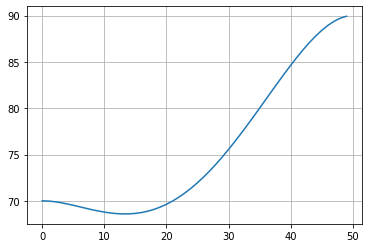

In [87]:
x1, x2, x3 = 0, 35, 50
y1, y2, y3 = 70, 80, 90
alpha = 0

A = np.array([[x1*x1*x1, x1**2, x1, 1],
              [x2*x2*x2, x2**2, x2, 1],
              [x3*x3*x3, x3**2, x3, 1],
              [3*x2**2,  2*x2,  1,  0]])

A = np.array([[x1*x1*x1, x1**2, x1, 1],
              [x2*x2*x2, x2**2, x2, 1],
              [x3*x3*x3, x3**2, x3, 1],
              [3*x1**2,  2*x1,  1,  0]])

A = np.array([[x1**2**2, x1*x1*x1, x1**2, x1, 1],
              [x2**2**2, x2*x2*x2, x2**2, x2, 1],
              [x3**2**2, x3*x3*x3, x3**2, x3, 1],
              [4*x1*x1*x1, 3*x1**2,  2*x1,  1,0],
              [4*x3*x3*x3, 3*x3**2,  2*x3,  1,0]])

b = np.array([[y1, y2, y3, 0, 0]]).T
x = np.linalg.inv(A) @ b

y = []
for t in range(x3):
    # y.append(x[0]*t*t*t + x[1]*t**2 + x[2]*t + x[3])
    y.append(x[0]*t*t*t*t + x[1]*t*t*t + x[2]*t**2 + x[3]*t + x[4])
plt.plot(y)
plt.grid()

In [83]:
(3**2)**2

81

In [76]:
b

array([[70.],
       [80.],
       [90.],
       [ 1.]])

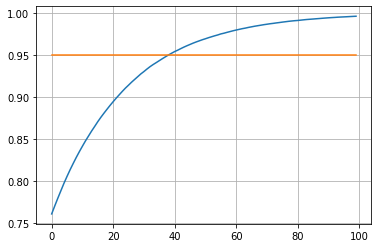

In [8]:
m1 = (torch.rand(config.hid, config.hid) > 0.75).int() * (1-torch.eye(config.hid, config.hid)).int()
log = []
N = 100
for i in range(N):
    m1 = m1&((torch.rand(config.hid, config.hid) > 0.04) * (1-torch.eye(config.hid, config.hid))).int()
    log.append((m1==0).sum().item()/config.hid**2)
plt.plot(log);plt.plot([0.95]*N);plt.grid()

In [233]:
config.l1_targ = 50000
config.dropout = 0.01
config.dropout_stepping = 0.01
config.dropout_stop = 0.05
# model = RC().to(config.device)
model = RC_revise().to(config.device)
# model = RC_RadLIF().to(config.device)
# model = RC_parallel().to(config.device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), 
                              lr=config.lr,
                              weight_decay=config.weight_decay)
acc = train(model, optimizer, criterion, config.epoch, train_loader, test_loader, 'cuda', mode='serial')

epoch:0,	Loss:5.5747,	Tr Acc:4.8022,	Ts Acc:4.9470,	Time:144.2911,	A Norm:18676.1836
epoch:1,	Loss:4.2075,	Tr Acc:5.0351,	Ts Acc:5.1237,	Time:52.2213,	A Norm:18550.8965
epoch:2,	Loss:4.6954,	Tr Acc:4.9534,	Ts Acc:4.4170,	Time:49.8121,	A Norm:18452.0547


KeyboardInterrupt: 

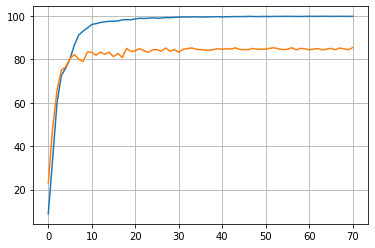

In [97]:
with open('temp.txt', 'r') as f:
    data = f.readlines()
loss = []
Anorm = []
for d in data:
    loss.append(float(d.split('Tr Accuracy:  ')[1].split(' . Ts Accuracy')[0]))
    Anorm.append(float(d.split(' . Ts Accuracy:  ')[1].split(' . Fr:  ')[0]))
plt.plot(loss)
plt.plot(Anorm)
plt.grid()

In [322]:
# params = sum(param.numel() for param in model.parameters() if param.requires_grad)
# print("Parameters: {:.6f}M".format(params / 1e6))
(model.A3.weight.data.abs()==0.0).sum()/config.hid**2

tensor(0.8924, device='cuda:0')

# Multiple trials

In [31]:
def multiple_trial():
    train_acc_log = np.zeros((config.epoch, config.trials))
    test_acc_log = np.zeros((config.epoch, config.trials))
    for i in range(config.trials):
        print('************** ', i, ' **************')
        np.random.seed(config.seed+i)
        torch.manual_seed(config.seed+i)
        torch.cuda.manual_seed_all(config.seed+i)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        # model = RC().to(config.device)
        model = RC_RadLIF().to(config.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=config.lr, weight_decay=config.weight_decay)
        # optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=config.lr)
        train_acc, test_acc = train(model, optimizer, criterion, config.epoch, train_loader, test_loader, config.device, 'serial')
        
        # accuracy = test(model, test_loader, mode='serial')
        train_acc_log[:,i] = train_acc
        test_acc_log[:,i] = test_acc
    return train_acc_log, test_acc_log

def plot_errorbar(train_acc_log, test_acc_log, file_name):
    train_mean = np.mean(train_acc_log, axis=1)
    train_std = np.std(train_acc_log, axis=1)
    train_var = np.var(train_acc_log, axis=1)
    train_max = np.max(train_acc_log, axis=1)
    train_min = np.min(train_acc_log, axis=1)

    test_mean = np.mean(test_acc_log, axis=1)
    test_std = np.std(test_acc_log, axis=1)
    test_var = np.var(test_acc_log, axis=1)
    test_max = np.max(test_acc_log, axis=1)
    test_min = np.min(test_acc_log, axis=1)

    plt.plot(list(range(config.epoch)), train_mean, color='deeppink', label='train mean')
    # plt.fill_between(list(range(config.epoch)), data_mean-data_std, data_mean+data_std, color='violet', alpha=0.2)
    plt.fill_between(list(range(config.epoch)), train_min, train_max, color='violet', alpha=0.2)

    plt.plot(list(range(config.epoch)), test_mean, color='blue', label='test mean')
    # plt.fill_between(list(range(config.epoch)), data_mean-data_std, data_mean+data_std, color='violet', alpha=0.2)
    plt.fill_between(list(range(config.epoch)), test_min, test_max, color='blue', alpha=0.2)

    plt.legend()
    plt.grid()
    # plt.axis([-5, 105, 75, 95])
    plt.savefig(file_name)
    # plt.show()

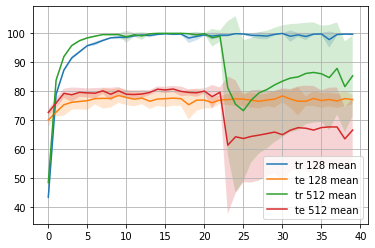

In [45]:
train_mean = np.mean(tr_acc_log1, axis=1)
train_std = np.std(tr_acc_log1, axis=1)
train_var = np.var(tr_acc_log1, axis=1)
train_max = np.max(tr_acc_log1, axis=1)
train_min = np.min(tr_acc_log1, axis=1)

test_mean = np.mean(te_acc_log1, axis=1)
test_std = np.std(te_acc_log1, axis=1)
test_var = np.var(te_acc_log1, axis=1)
test_max = np.max(te_acc_log1, axis=1)
test_min = np.min(te_acc_log1, axis=1)

plt.plot(list(range(config.epoch)), train_mean, label='tr 128 mean')
plt.fill_between(list(range(config.epoch)), train_mean-train_std, train_mean+train_std, alpha=0.2)
# plt.fill_between(list(range(config.epoch)), train_min, train_max, alpha=0.2)

plt.plot(list(range(config.epoch)), test_mean, label='te 128 mean')
plt.fill_between(list(range(config.epoch)), test_mean-test_std, test_mean+test_std, alpha=0.2)
# plt.fill_between(list(range(config.epoch)), test_min, test_max, alpha=0.2)

train_mean = np.mean(tr_acc_log4, axis=1)
train_std = np.std(tr_acc_log4, axis=1)
train_var = np.var(tr_acc_log4, axis=1)
train_max = np.max(tr_acc_log4, axis=1)
train_min = np.min(tr_acc_log4, axis=1)

test_mean = np.mean(te_acc_log4, axis=1)
test_std = np.std(te_acc_log4, axis=1)
test_var = np.var(te_acc_log4, axis=1)
test_max = np.max(te_acc_log4, axis=1)
test_min = np.min(te_acc_log4, axis=1)

plt.plot(list(range(config.epoch)), train_mean, label='tr 512 mean')
plt.fill_between(list(range(config.epoch)), train_mean-train_std, train_mean+train_std, alpha=0.2)
# plt.fill_between(list(range(config.epoch)), train_min, train_max, alpha=0.2)

plt.plot(list(range(config.epoch)), test_mean, label='te 512 mean')
plt.fill_between(list(range(config.epoch)), test_mean-test_std, test_mean+test_std, alpha=0.2)
# plt.fill_between(list(range(config.epoch)), test_min, test_max, alpha=0.2)

plt.legend()
plt.grid()
# plt.axis([-5, 105, 75, 95])

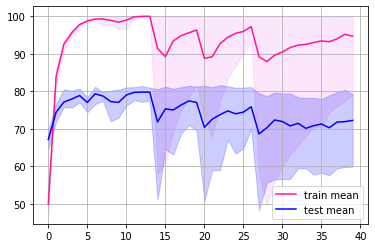

In [41]:
# plot_errorbar(tr_acc_log1, te_acc_log1, 'SHD_gradual_mask-RadLIF128-0.7-0.01-1e-4.pdf')
# plot_errorbar(tr_acc_log2, te_acc_log2, 'SHD_gradual_mask-RadLIF512-0.7-0.01-1e-4.pdf')
plot_errorbar(tr_acc_log3, te_acc_log3, 'SHD_gradual_mask-RadLIF1024-0.7-0.01-1e-4.pdf')


In [33]:
config.hid = 128
tr_acc_log1, te_acc_log1 = multiple_trial() # file_name='SHD_gradual_mask_RadLIF-128-0.7-0.01-1e-4.pdf'

**************  0  **************


C:\Users\Administrator\AppData\Local\Temp\ipykernel_9140\3174555683.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sum1_mem += F.softmax(hid1_mem_tmp)


epoch:0,	Loss:1.2048,	Tr Acc:38.7567,	Ts Acc:68.2862,	Time:10.8624,	A Norm:400.6653
epoch:1,	Loss:0.5864,	Tr Acc:77.6851,	Ts Acc:70.5389,	Time:10.0221,	A Norm:485.9229
epoch:2,	Loss:0.4039,	Tr Acc:86.5457,	Ts Acc:70.7155,	Time:9.9634,	A Norm:531.5358
epoch:3,	Loss:0.2556,	Tr Acc:91.0291,	Ts Acc:71.2898,	Time:9.8725,	A Norm:562.4136
epoch:4,	Loss:0.2328,	Tr Acc:94.0698,	Ts Acc:72.7915,	Time:9.8818,	A Norm:584.7535
epoch:5,	Loss:0.2158,	Tr Acc:95.4798,	Ts Acc:72.3940,	Time:9.9512,	A Norm:601.3290
epoch:6,	Loss:0.1096,	Tr Acc:96.9879,	Ts Acc:75.0442,	Time:10.0249,	A Norm:616.1682
epoch:7,	Loss:0.0767,	Tr Acc:97.9443,	Ts Acc:72.3057,	Time:9.9962,	A Norm:625.9795
epoch:8,	Loss:0.0804,	Tr Acc:97.9197,	Ts Acc:73.1007,	Time:9.9674,	A Norm:633.4474
epoch:9,	Loss:0.0488,	Tr Acc:99.1990,	Ts Acc:74.9558,	Time:9.8939,	A Norm:639.5889
epoch:10,	Loss:0.0700,	Tr Acc:97.1596,	Ts Acc:73.3216,	Time:10.0116,	A Norm:642.8301
epoch:11,	Loss:0.0345,	Tr Acc:98.5287,	Ts Acc:74.3816,	Time:10.0776,	A Norm:651.39

In [43]:
config.hid = 512
config.l1 = 0
config.weight_decay = 1e-5
tr_acc_log4, te_acc_log4 = multiple_trial() # file_name='SHD_gradual_mask_RadLIF-512-0.7-0.01-1e-4.pdf'

**************  0  **************


C:\Users\Administrator\AppData\Local\Temp\ipykernel_9140\3174555683.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sum1_mem += F.softmax(hid1_mem_tmp)


epoch:0,	Loss:0.9904,	Tr Acc:48.7371,	Ts Acc:71.4664,	Time:14.4407,	A Norm:4256.7959
epoch:1,	Loss:0.3693,	Tr Acc:85.3768,	Ts Acc:76.4576,	Time:12.3336,	A Norm:4894.3188
epoch:2,	Loss:0.2302,	Tr Acc:92.6761,	Ts Acc:81.0071,	Time:12.2987,	A Norm:5268.2598
epoch:3,	Loss:0.2009,	Tr Acc:95.9498,	Ts Acc:81.7580,	Time:12.5137,	A Norm:5483.8857
epoch:4,	Loss:0.0823,	Tr Acc:97.6663,	Ts Acc:82.0230,	Time:12.2868,	A Norm:5661.5098
epoch:5,	Loss:0.0451,	Tr Acc:98.7903,	Ts Acc:79.3728,	Time:12.2400,	A Norm:5745.0591
epoch:6,	Loss:0.0376,	Tr Acc:99.1009,	Ts Acc:78.9753,	Time:12.1998,	A Norm:5822.8188
epoch:7,	Loss:0.0203,	Tr Acc:99.6608,	Ts Acc:81.8463,	Time:12.2424,	A Norm:5875.9209
epoch:8,	Loss:0.0495,	Tr Acc:99.0191,	Ts Acc:81.1837,	Time:12.2926,	A Norm:5966.2529
epoch:9,	Loss:0.0150,	Tr Acc:99.6649,	Ts Acc:79.3728,	Time:12.2752,	A Norm:6021.7939
epoch:10,	Loss:0.0083,	Tr Acc:99.9591,	Ts Acc:79.9470,	Time:12.2224,	A Norm:6015.6309
epoch:11,	Loss:0.0146,	Tr Acc:99.8692,	Ts Acc:76.2367,	Time:12.1

In [35]:
config.hid = 1024
tr_acc_log3, te_acc_log3 = multiple_trial() # file_name='SHD_gradual_mask_RadLIF-1024-0.7-0.01-1e-4.pdf'

**************  0  **************


C:\Users\Administrator\AppData\Local\Temp\ipykernel_9140\3174555683.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sum1_mem += F.softmax(hid1_mem_tmp)


epoch:0,	Loss:1.0299,	Tr Acc:49.9305,	Ts Acc:64.3993,	Time:15.2839,	A Norm:14145.9160
epoch:1,	Loss:0.4619,	Tr Acc:82.1726,	Ts Acc:76.7226,	Time:14.7252,	A Norm:15932.8516
epoch:2,	Loss:0.2779,	Tr Acc:91.1027,	Ts Acc:80.5654,	Time:14.7349,	A Norm:16855.8438
epoch:3,	Loss:0.1450,	Tr Acc:94.5807,	Ts Acc:80.1678,	Time:14.7163,	A Norm:17576.6250
epoch:4,	Loss:0.0876,	Tr Acc:97.8993,	Ts Acc:80.7420,	Time:14.8435,	A Norm:17915.4258
epoch:5,	Loss:0.0466,	Tr Acc:98.7739,	Ts Acc:78.4452,	Time:14.8343,	A Norm:18120.0156
epoch:6,	Loss:0.0369,	Tr Acc:99.2480,	Ts Acc:81.2279,	Time:14.9404,	A Norm:18247.5957
epoch:7,	Loss:0.0372,	Tr Acc:99.4850,	Ts Acc:79.6820,	Time:14.8212,	A Norm:18425.6953
epoch:8,	Loss:0.0484,	Tr Acc:98.3407,	Ts Acc:76.8993,	Time:14.9117,	A Norm:18805.2422
epoch:9,	Loss:0.0616,	Tr Acc:98.0383,	Ts Acc:79.9028,	Time:14.8875,	A Norm:19227.5059
epoch:10,	Loss:0.0204,	Tr Acc:99.4401,	Ts Acc:79.7261,	Time:14.7319,	A Norm:19402.7500
epoch:11,	Loss:0.0081,	Tr Acc:99.9264,	Ts Acc:81.0954

**************  0  **************
epoch:0,	Loss:0.8738,	Tr Acc:44.8831,	Ts Acc:62.3233,	Time:21.0701,	A Norm:1466.3540
epoch:1,	Loss:0.5640,	Tr Acc:78.9071,	Ts Acc:71.9523,	Time:20.9718,	A Norm:1781.1826
epoch:2,	Loss:0.2623,	Tr Acc:88.0620,	Ts Acc:76.0159,	Time:19.9371,	A Norm:1961.3462
epoch:3,	Loss:0.2275,	Tr Acc:92.1653,	Ts Acc:77.9594,	Time:19.9941,	A Norm:1986.5841
epoch:4,	Loss:0.1829,	Tr Acc:94.4376,	Ts Acc:73.4982,	Time:20.3064,	A Norm:1989.6565
epoch:5,	Loss:0.1103,	Tr Acc:95.7169,	Ts Acc:72.3940,	Time:19.7823,	A Norm:1988.9277
epoch:6,	Loss:0.1130,	Tr Acc:96.7999,	Ts Acc:74.7350,	Time:19.9671,	A Norm:1990.5408
epoch:7,	Loss:0.0446,	Tr Acc:98.7249,	Ts Acc:72.8357,	Time:19.6160,	A Norm:1987.1250
epoch:8,	Loss:0.0405,	Tr Acc:99.3216,	Ts Acc:75.8392,	Time:20.1994,	A Norm:1984.5719
epoch:9,	Loss:0.0904,	Tr Acc:94.9403,	Ts Acc:76.0601,	Time:21.4535,	A Norm:1989.8813
epoch:10,	Loss:0.0396,	Tr Acc:99.1908,	Ts Acc:76.9876,	Time:22.2518,	A Norm:1989.9540
epoch:11,	Loss:0.0253,	Tr Acc:

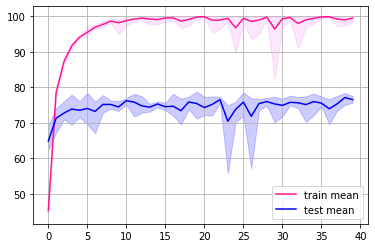

In [546]:
multiple_trial(file_name='SHD_gradual_mask_LIF-0.7-0.01-1e-4.pdf')

**************  0  **************
epoch:0,	Loss:2.2172,	Tr Acc:14.1532,	Ts Acc:32.5530,	Time:10.8293,	A Norm:119.4848
epoch:1,	Loss:1.5213,	Tr Acc:45.8803,	Ts Acc:60.1590,	Time:10.2631,	A Norm:160.8439
epoch:2,	Loss:1.2302,	Tr Acc:64.1859,	Ts Acc:64.1343,	Time:9.7954,	A Norm:185.6017
epoch:3,	Loss:0.9357,	Tr Acc:73.4551,	Ts Acc:70.4064,	Time:9.1255,	A Norm:203.6504
epoch:4,	Loss:0.8351,	Tr Acc:79.2750,	Ts Acc:70.6714,	Time:9.1866,	A Norm:215.2498
epoch:5,	Loss:0.8097,	Tr Acc:83.3824,	Ts Acc:73.5424,	Time:9.0379,	A Norm:224.3219
epoch:6,	Loss:0.5959,	Tr Acc:86.2106,	Ts Acc:75.8834,	Time:9.0091,	A Norm:231.7963
epoch:7,	Loss:0.4116,	Tr Acc:87.2691,	Ts Acc:74.2933,	Time:9.0332,	A Norm:235.4663
epoch:8,	Loss:0.4519,	Tr Acc:88.9202,	Ts Acc:76.9876,	Time:9.0908,	A Norm:237.8122
epoch:9,	Loss:0.3646,	Tr Acc:90.9596,	Ts Acc:77.3410,	Time:9.1571,	A Norm:242.4401
epoch:10,	Loss:0.3018,	Tr Acc:90.9351,	Ts Acc:77.2968,	Time:9.1635,	A Norm:238.2348
epoch:11,	Loss:0.3311,	Tr Acc:92.7497,	Ts Acc:78.0

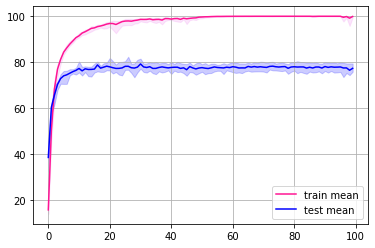

In [522]:
multiple_trial(file_name='SHD_gradual_mask_RadLIF-0.9-0.02-1e-4.pdf')

### SHD实验结论
 - 增加reservoir神经元数量，增益不显著
 - weight decay可以起到A矩阵的l1 norm的作用
 - 在学习过程中，通过l1 norm约束A矩阵的元素值，每轮修剪特小值/结束后修剪特小值，这跟weight decay原理一样
 - 每层reservoir后接一个fc，然后将若干个fc的结果拼起来，与直接将reservoir的输出进行拼接，改进不显著
 - input layer可学习，可以显著改进分类效果
 - 多层reservoir和单层reservoir，效果不显著？
 - RadLIF不会破坏性能

In [524]:
config.hid = 256
config.dropout = 0.8
multiple_trial(file_name='SHD_gradual_mask_RadLIF-256-0.9-0.02-1e-4.pdf')

**************  0  **************
epoch:0,	Loss:1.5679,	Tr Acc:27.2233,	Ts Acc:60.2915,	Time:11.9371,	A Norm:764.9865
epoch:1,	Loss:0.9225,	Tr Acc:69.0167,	Ts Acc:71.5989,	Time:10.7440,	A Norm:937.7399
epoch:2,	Loss:0.6242,	Tr Acc:81.0487,	Ts Acc:73.8958,	Time:10.7374,	A Norm:1026.2292
epoch:3,	Loss:0.5170,	Tr Acc:85.7079,	Ts Acc:71.6431,	Time:10.6402,	A Norm:1083.1411
epoch:4,	Loss:0.4526,	Tr Acc:88.8753,	Ts Acc:80.0353,	Time:10.6922,	A Norm:1126.1350
epoch:5,	Loss:0.4332,	Tr Acc:90.9474,	Ts Acc:76.7668,	Time:11.3767,	A Norm:1160.0752
epoch:6,	Loss:0.2282,	Tr Acc:92.8601,	Ts Acc:77.2527,	Time:10.9836,	A Norm:1185.2568
epoch:7,	Loss:0.1930,	Tr Acc:93.7960,	Ts Acc:79.9470,	Time:10.7654,	A Norm:1199.0762
epoch:8,	Loss:0.2068,	Tr Acc:95.1978,	Ts Acc:78.0477,	Time:10.8318,	A Norm:1214.4731
epoch:9,	Loss:0.1410,	Tr Acc:96.2441,	Ts Acc:79.8587,	Time:10.9413,	A Norm:1220.0581
epoch:10,	Loss:0.1714,	Tr Acc:97.1187,	Ts Acc:78.0477,	Time:11.0085,	A Norm:1223.8057
epoch:11,	Loss:0.1175,	Tr Acc:97

KeyboardInterrupt: 

In [ ]:
config.hid = 128
config.weight_decay = 5e-5
multiple_trial(file_name='SHD_gradual_mask_RadLIF-128-0.9-0.02-5e-5.pdf')

**************  0  **************
epoch:0,	Loss:2.2202,	Tr Acc:15.3874,	Ts Acc:22.3498,	Time:14.6798,	A Norm:1077.7009
epoch:1,	Loss:1.9415,	Tr Acc:29.3894,	Ts Acc:35.5565,	Time:14.3708,	A Norm:1280.4310
epoch:2,	Loss:1.4856,	Tr Acc:43.4159,	Ts Acc:45.4064,	Time:14.4014,	A Norm:1449.7632
epoch:3,	Loss:1.2383,	Tr Acc:51.7288,	Ts Acc:46.2014,	Time:14.3652,	A Norm:1580.7361
epoch:4,	Loss:1.1047,	Tr Acc:56.1182,	Ts Acc:53.1802,	Time:14.4737,	A Norm:1699.9587
epoch:5,	Loss:0.8895,	Tr Acc:62.8617,	Ts Acc:55.6979,	Time:14.4458,	A Norm:1793.7540
epoch:6,	Loss:1.0312,	Tr Acc:65.0441,	Ts Acc:57.5088,	Time:14.5360,	A Norm:1871.8496
epoch:7,	Loss:0.8273,	Tr Acc:69.0289,	Ts Acc:58.2155,	Time:14.3682,	A Norm:1938.0264
epoch:8,	Loss:0.8974,	Tr Acc:69.0535,	Ts Acc:59.5848,	Time:14.4717,	A Norm:2013.3496
epoch:9,	Loss:0.8783,	Tr Acc:71.8489,	Ts Acc:59.5406,	Time:14.4241,	A Norm:2072.0691
epoch:10,	Loss:0.7229,	Tr Acc:74.7057,	Ts Acc:60.7774,	Time:14.3642,	A Norm:2106.6328
epoch:11,	Loss:0.5274,	Tr Acc:

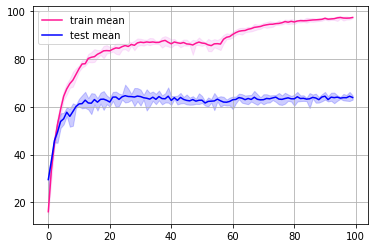

In [314]:
config.weight_decay = 1e-4
config.dropout_stepping = 0.02
config.l1_targ = 5000
multiple_trial(file_name='SHD_gradual_mask-0.7-0.02-1e-4-5000.pdf')

In [183]:
(model.A2.weight.data==0).sum()/128**2

tensor(0.9514, device='cuda:0')

# label smoothing

In [94]:
confidence = 1.0 - 0.1
pred = torch.rand(12, 5)

with torch.no_grad():
    true_dist = torch.zeros_like(pred)
    true_dist.fill_(config.smoothing / (config.output - 1))

    target = torch.randint(low=0, high=2, size=(12, ))
    true_dist.scatter_(1, target.unsqueeze(1), confidence)

In [95]:
true_dist

tensor([[0.0053, 0.9000, 0.0053, 0.0053, 0.0053],
        [0.0053, 0.9000, 0.0053, 0.0053, 0.0053],
        [0.9000, 0.0053, 0.0053, 0.0053, 0.0053],
        [0.0053, 0.9000, 0.0053, 0.0053, 0.0053],
        [0.0053, 0.9000, 0.0053, 0.0053, 0.0053],
        [0.0053, 0.9000, 0.0053, 0.0053, 0.0053],
        [0.9000, 0.0053, 0.0053, 0.0053, 0.0053],
        [0.9000, 0.0053, 0.0053, 0.0053, 0.0053],
        [0.9000, 0.0053, 0.0053, 0.0053, 0.0053],
        [0.9000, 0.0053, 0.0053, 0.0053, 0.0053],
        [0.9000, 0.0053, 0.0053, 0.0053, 0.0053],
        [0.9000, 0.0053, 0.0053, 0.0053, 0.0053]])

In [89]:
target = torch.randint(low=0, high=2, size=(12, ))
target.shape

torch.Size([12])

# Test

In [240]:
with torch.no_grad():
    for i in range(10):
        np.random.seed(i)
        torch.manual_seed(i)
        torch.cuda.manual_seed_all(i)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
        print(test(model, test_loader))

93.08
93.26
93.3
92.91
93.12
93.01
93.04
93.23
93.13
93.08


In [242]:
np.mean([93.08,93.26,93.3,92.91,93.12,93.01,93.04,93.23,93.13,93.08])

93.116

# Pruning

In [278]:
# 1-(model.A.weight.abs()<8.5e-3).sum()/65536
(model.A2.weight.abs()<=2e-3).sum()/128/128

tensor(0.8840, device='cuda:0')

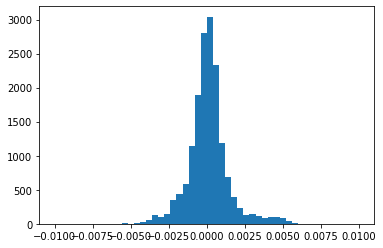

In [283]:
stat = plt.hist(model.A2.weight.flatten().detach().cpu().numpy(), bins=50, range=[-0.01, 0.01])

In [282]:
RC_model = deepcopy(model)
with torch.no_grad():
    baseline = 10e-3
    RC_model.A1.weight[RC_model.A1.weight.abs() <= baseline] = 0
    baseline = 2e-3
    RC_model.A2.weight[RC_model.A2.weight.abs() <= baseline] = 0
    # RC_model.A.weight[RC_model.A.weight.abs() > baseline] = 1.0
    print(((RC_model.A1.weight==0).sum() + (RC_model.A2.weight==0).sum()) / (2*config.hid**2))
    
    acc_mean = []
    for i in range(10):
        np.random.seed(i)
        torch.manual_seed(i)
        torch.cuda.manual_seed_all(i)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        acc_mean.append(test(RC_model, test_loader))
    print(np.mean(acc_mean), acc_mean)
    

tensor(0.8588, device='cuda:0')
93.12899999999999 [93.06, 93.35, 93.21, 92.88, 93.23, 93.03, 93.04, 93.24, 93.15, 93.1]


In [158]:
A = RC_model.A.weight.cpu().data.numpy()
x, y = np.where(A>baseline)
x_index = y_index = [0]*config.hid
for xx, yy in zip(x, y):
    x_index[xx] += 1
    y_index[yy] += 1
x_important = np.where(np.array(x_index)>40)[0]
y_important = np.where(np.array(y_index)>40)[0]
node_important = [0]*config.hid
for i in range(256):
    if x_index[i]>=40 and y_index[i]>=40:
        node_important[i] += 1
node_important = np.where(np.array(node_important)>=1)[0]

In [141]:
RC_model.thr += torch.rand(config.hid).to('cuda')*0.001
test(RC_model, test_loader)

90.27

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 256 (seed=266230, Thu Jun  8 12:11:51 2023)
0 -90.35
0 -90.22
0 -90.1
0 -90.03
0 -90.15
0 -90.25
0 -90.13
0 -90.04
0 -89.97
0 -90.19
1 -89.99
1 -89.99
1 -90.06
1 -90.13
1 -90.06
1 -90.18
1 -90.09
1 -90.19
1 -90.18
1 -90.05
2 -90.16
2 -90.25
2 -90.15
2 -90.14
2 -90.26
2 -90.0
2 -90.18
2 -90.15
2 -90.22
2 -90.12
3 -90.1
3 -90.22
3 -90.14
3 -90.17
3 -90.06
3 -90.11
3 -89.94
3 -90.1
3 -90.11
3 -90.24
4 -90.03
4 -90.17
4 -90.23
4 -90.1
4 -90.27
4 -90.1
4 -90.05
4 -90.0
4 -90.16
4 -90.09
5 -90.11
5 -90.14
5 -90.13
5 -89.93
5 -90.07
5 -90.13
5 -89.98
5 -90.1
5 -90.17
5 -90.14
6 -89.97
6 -90.2
6 -90.18
6 -90.2
6 -90.08
6 -89.9
6 -90.24
6 -90.27
6 -90.11
6 -89.99
7 -89.95
7 -90.1
7 -89.98
7 -90.2
7 -90.05
7 -90.19
7 -90.09
7 -90.02
7 -89.97
7 -90.07
8 -90.02
8 -90.15
8 -90.06
8 -90.15
8 -90.03
8 -90.07
8 -90.18
8 -90.02
8 -90.04
8 -90.14
9 -90.07
9 -90.12
9 -89.99
9 -90.18
9 -90.16
9 -90.03
9 -90.13
9 -90.2
9 -90.05
9 -90.15
10 -90.12
10 -90.13
1

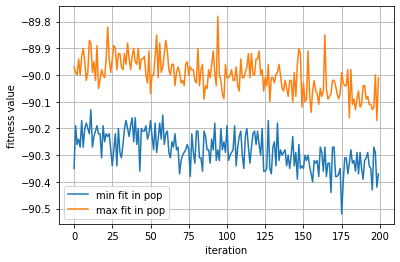

In [163]:
import cma

def fitness(x):
    tmp_model = deepcopy(RC_model)
    tmp_model.to('cpu')
    tmp_model.thr += torch.tensor(x)*0.01
    return -test(tmp_model, test_loader, device='cpu')

es = cma.CMAEvolutionStrategy(x0=[0.1]*256,
                                sigma0=0.1,
                                inopts={'popsize': 10}
                                )

log = []
for iteration in range(200):
    solutions = es.ask()
    fit = []
    for solution in solutions:
        fit_tmp = fitness(solution)
        fit.append(fit_tmp)
        print(iteration, fit_tmp)
        
    log.append([min(fit), max(fit)])
    es.tell(solutions, fit)

print('best solution\n', solutions[np.argmin(fit)])

log = np.array(log)
plt.plot(log[:,0])
plt.plot(log[:,1])
plt.grid()
plt.xlabel('iteration')
plt.ylabel('fitness value')
plt.legend(['min fit in pop', 'max fit in pop'])
plt.show()

In [17]:
model = RC()
non_zero, per_node = [], []
for i in range(config.hid):
    model.A[i,:] = 0
    model.A[:,i] = 0
    # print(i, (model.A!=0).sum(), (model.A!=0).sum()/256)
    non_zero.append((model.A!=0).sum().item())
    per_node.append((model.A!=0).sum().item()/config.hid)

# Learnable parameter calculation

In [213]:
from thop import profile

model_tmp = RC().to('cuda')
params = sum(param.numel() for param in model_tmp.parameters() if param.requires_grad)
print("Parameters: {:.6f}M".format(params / 1e6))

# input = torch.randn(1, 20, 2, 34, 34).cuda() #.to(config.device)
# flops, params = profile(model_tmp.cuda(), inputs=(input,))
# print("FLOPS: {:.2f}M".format(flops / 1e6))
# print("Parameters: {:.2f}K".format(params / 1e3))

Parameters: 2.117642M


In [ ]:
def GLIF_mem_update(input, dt, thr_v, thr_s, thr_inf, av, bv, E_L):
    V = 
    
    thr_v += dt * (av*(V-E_L) - bv*thr_v)
    
    thr = thr_v + thr_s + thr_inf
    

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

thresh = 0.15
lens = 0.5
probs = 0.5
decay = 0.6

cfg_cnn = [(2, 64, 3, 1, 3),
           (64, 128, 2, 1, 3),
           (128, 256, 2, 1, 3),
            (256, 256, 1, 1, 3),
           ]
cfg_fc = [512, 512, 200]

def mem_update(opts, x, mem, spike):
    mem = mem * decay * (1 - spike) + opts(x)
    spike = act_fun(mem - thresh)
    return mem, spike

class ActFun(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input.gt(0).float()

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        temp = abs(input)<lens
        return grad_input * temp.float()
act_fun = ActFun.apply


def mem_update(opts, x, mem, spike):
    mem = mem * decay * (1 - spike) + opts(x)
    spike = act_fun(mem - thresh)
    return mem, spike

class SNN(nn.Module):
    def __init__(self, **kwargs):
        super(SNN, self).__init__()
        self.device = kwargs.get('device')

        in_planes, out_planes, stride, padding, kernel_size = cfg_cnn[0]
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding)

        in_planes, out_planes, stride, padding, kernel_size = cfg_cnn[1]
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn2 = nn.BatchNorm2d(in_planes)

        in_planes, out_planes, stride, padding, kernel_size = cfg_cnn[2]
        self.conv3 = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn3 = nn.BatchNorm2d(in_planes)

        in_planes, out_planes, stride, padding, kernel_size = cfg_cnn[3]
        self.conv4 = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn4 = nn.BatchNorm2d(in_planes)

        inp_dim = 5 * 7 * out_planes
        self.fc1 = nn.Linear(inp_dim, cfg_fc[0])
        self.fc2 = nn.Linear(cfg_fc[0], cfg_fc[1])

    def forward(self, dvs_inp, out_mode = 'rate'):
        batch_size, seq_len, channel, w, h = dvs_inp.size()
        dvs_inp = dvs_inp.permute([1,0,2,3,4])
        c1_mem = c1_spike = torch.zeros(batch_size, cfg_cnn[0][1], 44, 58, device=self.device)
        c2_mem = c2_spike = torch.zeros(batch_size, cfg_cnn[1][1], 22, 29, device=self.device)
        c3_mem = c3_spike = torch.zeros(batch_size, cfg_cnn[2][1], 11, 15, device=self.device)
        c4_mem = c4_spike = torch.zeros(batch_size, cfg_cnn[3][1], 11, 15, device=self.device)

        h1_sum = h1_mem = h1_spike = torch.zeros(batch_size, cfg_fc[0], device=self.device)
        h2_sum = h2_mem = h2_spike = torch.zeros(batch_size, cfg_fc[1], device=self.device)
        out_spike = torch.zeros(seq_len, batch_size, cfg_fc[1], device=self.device)
        for step in range(seq_len):
            spike_inp = dvs_inp[step]
            c1_mem, c1_spike = mem_update(self.conv1, spike_inp.float(), c1_mem, c1_spike)
            c2_mem, c2_spike = mem_update(self.conv2, self.bn2(c1_spike), c2_mem, c2_spike)
            c3_mem, c3_spike = mem_update(self.conv3, self.bn3(c2_spike), c3_mem, c3_spike)
            # c4_mem, c4_spike = mem_update(self.conv4, c3_spike, c4_mem, c4_spike)
            c4_mem, c4_spike = mem_update(self.conv4, self.bn4(c3_spike), c4_mem, c4_spike)
            x = F.avg_pool2d(c4_spike, 2).view(batch_size, -1)

            h1_mem, h1_spike = mem_update(self.fc1, x, h1_mem, h1_spike)
            h2_mem, h2_spike = mem_update(self.fc2, h1_spike, h2_mem, h2_spike)
            h2_sum += h2_spike
            out_spike[step] = h2_spike
        out = h2_sum / seq_len
        if out_mode == 'time':
            out = out_spike
        else:
            out = h2_sum / seq_len
        return out


In [ ]:
import os
import torch
import torch.utils.model_zoo
import torchvision.models as models
from src.model.snn import *
from src.model.cann import CANN
from src.tools.utils import *

os.environ['CUDA_VISIBLE_DEVICES'] = "3"
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

class MHNN(nn.Module):
    def __init__(self, **kwargs):
        super(MHNN, self).__init__()

        self.cnn_arch = kwargs.get('cnn_arch')
        self.num_class = kwargs.get('num_class')
        self.cann_num = kwargs.get('cann_num')
        self.rnn_num = kwargs.get('rnn_num')
        self.lr = kwargs.get('lr')
        self.batch_size = kwargs.get('batch_size')
        self.sparse_lambdas = kwargs.get('sparse_lambdas')
        self.r = kwargs.get('r')

        self.reservoir_num = kwargs.get('reservoir_num')
        self.threshold = kwargs.get('spiking_threshold')

        self.num_epoch = kwargs.get('num_epoch')
        self.num_iter = kwargs.get('num_iter')
        self.w_fps = kwargs.get('w_fps')
        self.w_gps = kwargs.get('w_gps')
        self.w_dvs = kwargs.get('w_dvs')
        self.w_head = kwargs.get('w_head')
        self.w_time = kwargs.get('w_time')

        self.seq_len_aps = kwargs.get('seq_len_aps')
        self.seq_len_gps = kwargs.get('seq_len_gps')
        self.seq_len_dvs = kwargs.get('seq_len_dvs')
        self.seq_len_head = kwargs.get('seq_len_head')
        self.seq_len_time = kwargs.get('seq_len_time')
        self.dvs_expand = kwargs.get('dvs_expand')

        self.ann_pre_load = kwargs.get('ann_pre_load')
        self.snn_pre_load = kwargs.get('snn_pre_load')
        self.re_trained = kwargs.get('re_trained')

        self.train_exp_idx = kwargs.get('train_exp_idx')
        self.test_exp_idx = kwargs.get('test_exp_idx')

        self.data_path = kwargs.get('data_path')
        self.snn_path = kwargs.get('snn_path')

        #self.device = kwargs.get('device')
        self.device = device

        if self.ann_pre_load:
            print("=> Loading pre-trained model '{}'".format(self.cnn_arch))
            self.cnn = models.__dict__[self.cnn_arch](pretrained=self.ann_pre_load)
        else:
            print("=> Using randomly inizialized model '{}'".format(self.cnn_arch))
            self.cnn = models.__dict__[self.cnn_arch](pretrained=self.ann_pre_load)

        if self.cnn_arch == "mobilenet_v2":
            """ MobileNet """
            self.feature_dim = self.cnn.classifier[1].in_features
            self.cnn.classifier[1] = nn.Identity()

        elif self.cnn_arch == "resnet50":
            """ Resnet50 """

            self.feature_dim = 512

            # self.cnn.layer1 = nn.Identity()
            self.cnn.layer2 = nn.Identity()
            self.cnn.layer3 = nn.Identity()
            self.cnn.layer4 = nn.Identity()
            self.cnn.fc = nn.Identity()

            self.cnn.layer1[1] = nn.Identity()
            self.cnn.layer1[2] = nn.Identity()

            # self.cnn.layer2[0] = nn.Identity()
            # self.cnn.layer2[0].conv2 = nn.Identity()
            # self.cnn.layer2[0].bn2 = nn.Identity()

            fc_inputs = 256
            self.cnn.fc = nn.Linear(fc_inputs,self.feature_dim)

        else:
            print("=> Please check model name or configure architecture for feature extraction only, exiting...")
            exit()

        for param in self.cnn.parameters():
            param.requires_grad = self.re_trained

        #############
        # SNN module
        #############
        self.snn = SNN(device = self.device).to(self.device)
        self.snn_out_dim = self.snn.fc2.weight.size()[1]
        self.ann_out_dim = self.feature_dim
        self.cann_out_dim = 4 * self.cann_num
        self.reservior_inp_num = self.ann_out_dim + self.snn_out_dim + self.cann_out_dim
        self.LN = nn.LayerNorm(self.reservior_inp_num)
        if self.snn_pre_load:
            self.snn.load_state_dict(torch.load(self.snn_path)['snn'])

        #############
        # CANN module
        #############
        self.cann_num = self.cann_num
        self.cann = None
        self.num_class = self.num_class

        #############
        # MLSM module
        #############
        self.input_size = self.feature_dim
        self.reservoir_num = self.reservoir_num

        self.threshold = 0.5

        self.decay = nn.Parameter(torch.rand(self.reservoir_num))

        self.K = 128
        self.num_block = 5
        self.num_blockneuron = int(self.reservoir_num / self.num_block)

        self.decay_scale = 0.5
        self.beta_scale = 0.1

        self.thr_base1 = self.threshold

        self.thr_beta1 = nn.Parameter(self.beta_scale * torch.rand(self.reservoir_num))

        self.thr_decay1 = nn.Parameter(self.decay_scale * torch.rand(self.reservoir_num))

        self.ref_base1 = self.threshold
        self.ref_beta1 = nn.Parameter(self.beta_scale * torch.rand(self.reservoir_num))
        self.ref_decay1 = nn.Parameter(self.decay_scale * torch.rand(self.reservoir_num))

        self.cur_base1 = 0
        self.cur_beta1 = nn.Parameter(self.beta_scale * torch.rand(self.reservoir_num))
        self.cur_decay1 = nn.Parameter(self.decay_scale * torch.rand(self.reservoir_num))

        self.project = nn.Linear(self.reservior_inp_num, self.reservoir_num)

        self.project_mask_matrix = torch.zeros((self.reservior_inp_num, self.reservoir_num))


        input_node_list = [0, self.ann_out_dim, self.snn_out_dim, self.cann_num * 2, self.cann_num]

        input_cum_list = np.cumsum(input_node_list)

        for i in range(len(input_cum_list) - 1):
            self.project_mask_matrix[input_cum_list[i]:input_cum_list[i + 1],
            self.num_blockneuron * i:self.num_blockneuron * (i + 1)] = 1

        self.project.weight.data = self.project.weight.data * self.project_mask_matrix.t()

        self.lateral_conn = nn.Linear(self.reservoir_num, self.reservoir_num)

        self.lateral_conn_mask = torch.rand(self.reservoir_num, self.reservoir_num) > 0.8

        self.lateral_conn_mask = self.lateral_conn_mask * (1 - torch.eye(self.reservoir_num, self.reservoir_num))

        self.lateral_conn.weight.data = 0 * self.lateral_conn.weight.data * self.lateral_conn_mask.T

        #############
        # readout module
        #############

        # self.mlp1 = nn.Linear(self.reservoir_num, 256)
        # self.mlp2 = nn.Linear(256, self.num_class)
        self.mlp =  nn.Linear(self.reservoir_num, self.num_class)

    def cann_init(self, data):
        self.cann = CANN(data)

    def lr_initial_schedule(self, lrs=1e-3):
        hyper_param_list = ['decay',
                            'thr_beta1', 'thr_decay1',
                            'ref_beta1', 'ref_decay1',
                            'cur_beta1', 'cur_decay1']
        hyper_params = list(filter(lambda x: x[0] in hyper_param_list, self.named_parameters()))
        base_params = list(filter(lambda x: x[0] not in hyper_param_list, self.named_parameters()))
        hyper_params = [x[1] for x in hyper_params]
        base_params = [x[1] for x in base_params]
        optimizer = torch.optim.SGD(
            [
                {'params': base_params, 'lr': lrs},
                {'params': hyper_params, 'lr': lrs / 2},
            ], lr=lrs, momentum=0.9, weight_decay=1e-7
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, float(self.num_epoch))
        return optimizer, scheduler

    def wta_mem_update(self, fc, fv, k, inputx, spike, mem, thr, ref, last_cur):
        state = fc(inputx)
        mem = (mem - spike * ref) * self.decay + state + last_cur
        q0 = (100 -20)/100
        mem = mem.reshape(self.batch_size, self.num_blockneuron, -1)
        nps = torch.quantile(mem, q=q0, keepdim=True, axis=1)
        # nps =mem.max(axis=1,keepdim=True)[0] - thr

        mem = F.relu(mem - nps).reshape(self.batch_size, -1)

        spike = act_fun(mem - thr)
        return spike.float(), mem

    def trace_update(self, trace, spike, decay):
        return trace * decay + spike

    def forward(self, inp, epoch=100):
        aps_inp = inp[0].to(self.device)
        gps_inp = inp[1]
        dvs_inp = inp[2].to(self.device)
        head_inp = inp[3].to(self.device)

        batch_size, seq_len, channel, w, h = aps_inp.size()
        if self.w_fps > 0:
            aps_inp = aps_inp.view(batch_size * seq_len, channel, w, h)
            aps_out = self.cnn(aps_inp)
            out1 = aps_out.reshape(batch_size, self.seq_len_aps, -1).permute([1, 0, 2])
        else:
            out1 = torch.zeros(self.seq_len_aps, batch_size, -1, device=self.device).to(torch.float32)

        if self.w_dvs > 0:
            out2 = self.snn(dvs_inp, out_mode='time')
        else:
            out2 = torch.zeros(self.seq_len_dvs * 3, batch_size, self.snn_out_dim, device=self.device).to(torch.float32)

        ### CANN module
        if self.w_gps + self.w_head + self.w_time > 0:
            gps_record = []
            for idx in range(batch_size):
                buf = self.cann.update(torch.cat((gps_inp[idx],head_inp[idx].cpu()),axis=1), trajactory_mode=True)
                gps_record.append(buf[None, :, :, :])
            gps_out = torch.from_numpy(np.concatenate(gps_record)).cuda()
            gps_out = gps_out.permute([1, 0, 2, 3]).reshape(self.seq_len_gps, batch_size, -1)
        else:
            gps_out = torch.zeros((self.seq_len_gps, batch_size, self.cann_out_dim), device=self.device)

        # A generic CANN module was used for rapid testing; CANN1D/2D are provided in cann.py
        out3 = gps_out[:, :, self.cann_num:self.cann_num * 3].to(self.device).to(torch.float32)  # position
        out4 = gps_out[:, :, : self.cann_num].to(self.device).to(torch.float32)  # time
        out5 = gps_out[:, :, - self.cann_num:].to(self.device).to(torch.float32)  # direction

        out3 *= self.w_gps
        out4 *= self.w_time
        out5 *= self.w_head

        expand_len = int(self.seq_len_gps * self.seq_len_aps / np.gcd(self.seq_len_gps, self.seq_len_dvs) * self.dvs_expand)
        input_num = self.feature_dim + self.snn.fc2.weight.size()[1] + self.cann_num * self.dvs_expand

        r_spike = r_mem = r_sumspike = torch.zeros(batch_size, self.reservoir_num, device=self.device)

        thr_trace = torch.zeros(batch_size, self.reservoir_num, device=self.device)
        ref_trace = torch.zeros(batch_size, self.reservoir_num, device=self.device)
        cur_trace = torch.zeros(batch_size, self.reservoir_num, device=self.device)

        K_winner = self.K * (1 + np.clip(self.num_epoch - epoch, a_min=0, a_max=self.num_epoch) / self.num_epoch)

        out1_zeros = torch.zeros_like(out1[0], device=self.device)
        out3_zeros = torch.zeros_like(out3[0], device=self.device)
        out4_zeros = torch.zeros_like(out4[0], device=self.device)
        out5_zeros = torch.zeros_like(out5[0], device=self.device)

        self.project.weight.data = self.project.weight.data * self.project_mask_matrix.t().cuda()
        self.lateral_conn.weight.data = self.lateral_conn.weight.data * self.lateral_conn_mask.T.cuda()

        self.decay.data = torch.clamp(self.decay.data, min=0, max=1.)
        self.thr_decay1.data = torch.clamp(self.thr_decay1.data, min=0, max=1.)
        self.ref_decay1.data = torch.clamp(self.ref_decay1.data, min=0, max=1)
        self.cur_decay1.data = torch.clamp(self.cur_decay1.data, min=0, max=1)

        for step in range(expand_len):

            idx = step % 3
            if idx == 2:
                combined_input = torch.cat((out1[step // 3], out2[step], out3[step // 3], out4[step // 3], out5[step // 3]), axis=1)
            else:
                combined_input = torch.cat((out1_zeros, out2[step],out3_zeros, out4_zeros, out5_zeros), axis=1)

            thr = self.thr_base1 + thr_trace * self.thr_beta1
            # ref = self.ref_base1 + ref_trace * self.ref_beta1 # option: ref = self.ref_base1
            ref = self.ref_base1
            cur = self.cur_base1 + cur_trace * self.cur_beta1

            inputx = combined_input.float()
            r_spike, r_mem = self.wta_mem_update(self.project, 
                                                 self.lateral_conn, 
                                                 K_winner, 
                                                 inputx, 
                                                 r_spike, 
                                                 r_mem,
                                                 thr, 
                                                 ref, 
                                                 cur)
            thr_trace = self.trace_update(thr_trace, r_spike, self.thr_decay1)
            ref_trace = self.trace_update(ref_trace, r_spike, self.ref_decay1)
            cur_trace = self.trace_update(cur_trace, r_spike, self.cur_decay1)
            r_sumspike = r_sumspike + r_spike

        # cat_out = F.dropout(r_sumspike, p=0.5, training=self.training)
        # out1 = self.mlp1(r_sumspike).relu()
        # out2 = self.mlp2(out1)
        out2 = self.mlp(r_sumspike)

        neuron_pop = r_sumspike.reshape(batch_size, -1, self.num_blockneuron).permute([1, 0, 2])
        return out2, (neuron_pop[0], neuron_pop[1])
